In [86]:
import sys
import numpy as np
import os
import pickle
from PIL import Image
from tempfile import mkdtemp
import matplotlib.pyplot as plt
import os.path as path
import scipy.io
sw_filename = path.join(mkdtemp(), 'sw.dat')
sb_filename = path.join(mkdtemp(), 'sb.dat')
C_filename = path.join(mkdtemp(), 'cfile.dat')
face_file = path.join(mkdtemp(), 'facefile.dat')

In [87]:
with open('facefile.txt', 'rb') as faces:
    # read the data as binary data stream
    allfaces = pickle.load(faces)
with open('personfile.txt', 'rb') as person:
    # read the data as binary data stream
    allperson = pickle.load(person)

In [88]:
facedata = np.memmap(face_file, dtype='float32', mode='w+', shape=(256*256,100))

In [89]:
i = 0
for face in allfaces:
    facedata[:,i] = face.flatten()
    i +=1

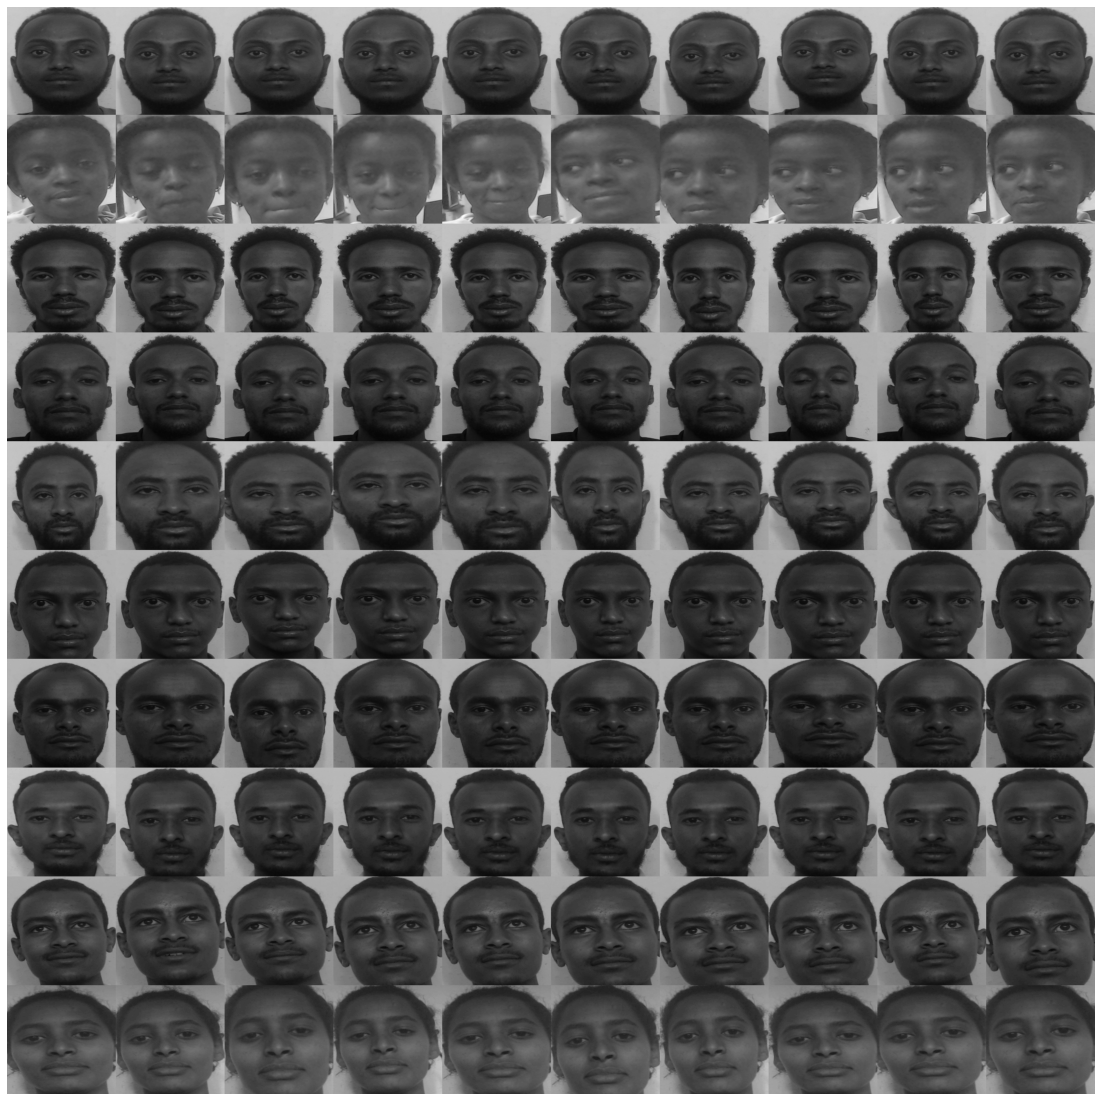

In [90]:
plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams.update({'font.size': 18})

m = 256
n = 256

allPersons = np.zeros((n*10,m*10))
count = 0

for j in range(10):
    for k in range(10):
        allPersons[j*n : (j+1)*n, k*m : (k+1)*m] = np.reshape(facedata[:,count],(m,n))
        count += 1
        
img = plt.imshow(allPersons)
img.set_cmap('gray')
plt.axis('off')
plt.show()

In [91]:
def pca (X , y , num_components =0) :
    [n , d] = X.shape
    C = np.memmap(C_filename, dtype='float32', mode='w+', shape=(d,d))
    if ( num_components <= 0) or ( num_components >n) :
        num_components = n
    mu = X.mean ( axis =0)
    X = X - mu
    if n > d:
        C = np.dot (X.T, X)
        [eigenvalues, eigenvectors] = np.linalg.eigh(C)
    else :
        C = np.dot (X, X.T)
        [ eigenvalues, eigenvectors ] = np.linalg.eigh(C)
        eigenvectors = np.dot (X.T, eigenvectors )
        for i in range (n):
            eigenvectors [: , i ] = eigenvectors [: , i ]/ np.linalg.norm(eigenvectors[: , i ])
    c = np . unique ( y)
    meanclasses = np.zeros((256, 2816), dtype=np.uint8)   
    for i in c:
        Xi = X[ np.where(y == i) [0] ,:]
        meanClass = Xi . mean ( axis =0)
        meanclasses[:,i*256:(i+1)*256] = np.asarray(meanClass, dtype=np.uint8).reshape(256,256)
    meanclasses[:,10*256:(10+1)*256] = np.asarray(mu, dtype=np.uint8).reshape(256,256)
    img = plt.imshow(meanclasses)
    img.set_cmap('gray')
    plt.axis('off')
    plt.show()
    
    # sort eigenvectors descending by their eigenvalue
    idx = np.argsort(- eigenvalues )
    eigenvalues = eigenvalues [ idx ]
    eigenvectors = eigenvectors [:, idx ]
    # select only num_components
    eigenvalues = eigenvalues [0: num_components ]. copy ()
    eigenvectors = eigenvectors [: ,0: num_components ]. copy ()
    return [ eigenvalues , eigenvectors , mu ]


In [92]:
def lda (X , y , num_components =0) :
    y = np . asarray (y)
    [n , d] = X.shape
    c = np . unique ( y)
    if ( num_components <= 0) or ( num_components >( len (c) -1) ):
        num_components = ( len (c) -1)
    meanTotal = X. mean ( axis =0)
    Sw = np.memmap(sw_filename, dtype='float32', mode='w+', shape=(d,d))
    Sb = np.memmap(sb_filename, dtype='float32', mode='w+', shape=(d,d))
    for i in c:
        Xi = X[ np.where(y == i) [0] ,:]
        meanClass = Xi . mean ( axis =0)
        Sw = Sw + np.dot (( Xi - meanClass ).T , ( Xi - meanClass ))
        Sb = Sb + n * np.dot (( meanClass - meanTotal ).T , ( meanClass - meanTotal ))
    
    eigenvalues , eigenvectors = np.linalg.eig ( np.linalg.inv( Sw )* Sb )
    idx = np.argsort ( - eigenvalues.real )
    eigenvalues , eigenvectors = eigenvalues [ idx ] , eigenvectors [: , idx ]
    eigenvalues = np.array ( eigenvalues [0: num_components ].real , dtype = np.float32 , copy = True )
    eigenvectors = np.array ( eigenvectors [0: ,0: num_components ].real , dtype = np.float32, copy = True )
    return [ eigenvalues , eigenvectors ]


In [93]:
def normalize(X, low, high , dtype=None): 
    X = np.asarray(X) 
    minX , maxX = np.min(X), np.max(X) # normalize to [0...1].
    X = X - float(minX) 
    X = X / float((maxX - minX)) # scale to [low...high]. 
    X = X * (high -low) 
    X = X + low 
    if dtype is None:
        return np.asarray(X) 
    return np.asarray(X, dtype=dtype)


In [94]:
def asRowMatrix(X): 
    if len(X) == 0: 
        return np.array([]) 
    mat = np.empty((0, X[0].size), dtype=X[0].dtype) 
    for row in X: 
        row = normalize(row, 0, 255 , dtype=None)
        mat = np.vstack((mat, np.asarray(row).reshape(1,-1))) 
    return mat

def asColumnMatrix(X): 
    if len(X) == 0: 
        return np.array([]) 
    mat = np.empty((X[0].size , 0), dtype=X[0].dtype) 
    for col in X: 
        mat = np.hstack((mat, np.asarray(col).reshape(-1,1))) 
    return mat


In [95]:
def project(W, X, mu=None): 
    if mu is None: 
        return np.dot(X,W) 
    return np.dot(X - mu, W)


In [96]:
def evaluate( X_test, y_test, projections): 
    positive = 0
    for i in range(len(y_test)):
        if (y_test[i] == predict(X_test[i], projections)):
            positive +=1
    accuracy = positive/len(y_test)
    return accuracy
def predict( X, projections): 
    minDist = np.finfo('float').max 
    minClass = -1 
    Q = project( W, X.reshape(1,-1), mu) 
    for i in range(len(projections)): 
        dist = np.linalg.norm(projections[i]-Q) 
        if dist < minDist: 
            minDist = dist 
            minClass = y[i] 
    return minClass


In [97]:
def fisherfaces (X ,y , num_components =0) :
    y = np . asarray (y)
    [n , d] = X.shape
   
    c = len ( np.unique (y ))
    [ eigenvalues_pca , eigenvectors_pca , mu_pca ] = pca (X, y, n)
    [ eigenvalues_lda , eigenvectors_lda ] = lda ( project ( eigenvectors_pca, X, mu_pca ), y, num_components)
    eigenvectors = np.dot ( eigenvectors_pca , eigenvectors_lda )
    return [ eigenvalues_lda , eigenvectors , mu_pca ]


In [98]:
def read_images(path , sz=None): 
    c = 0 
    X,y = [], [] 
    for dirname , dirnames , filenames in os.walk(r'C:/Users/nimona/Documents/ML/computer Vision/assignment2/faces/'): 
        for subdirname in dirnames: 
            subject_path = os.path.join(dirname , subdirname) 
            for filename in os.listdir(subject_path): 
                try:   
                    if filename.endswith('.png'):
                        fullName = os.path.join(subject_path, filename)    
                        im = Image.open(fullName) 
                        im = im.convert("L") 
                        # resize to given size (if given) 
                        if (sz is not None): 
                            im = im.resize(sz, Image.ANTIALIAS) 
                            X.append(np.asarray(im, dtype=np.uint8)) 
                            y.append(c) 
                except IOError: 
                    print ("I/O error({0}): {1}".format(errno , strerror))
                except:
                    print ("Unexpected error:", sys.exc_info()[0])
                    raise
            c = c+1
    return [X,y]


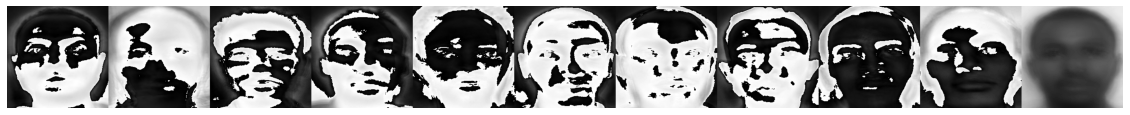

(9,)
(65536, 9)
(65536,)


In [99]:
# compute the eigenfaces model
[D , W , mu ] = fisherfaces ( asRowMatrix (allfaces ) ,allperson ,  num_components = 1000 )
print(D.shape)
print(W.shape)
print(mu.shape)


In [100]:
projections=[]
for xi in X :
    projections.append ( project ( W , xi . reshape (1 , -1) , mu ))

In [101]:
print("the accuracy of the model is",evaluate(X, y, projections)*100,"%")

the accuracy of the model is 100.0 %
